<a name="anker1"></a>
# 1質点系の運動方程式
---
下図のように質量mの質点が減衰係数c、バネ定数kで変位uで運動する場合を考える


<img src="./mass_motion_eq.gif">


この場合、運動方程式は次のとおりである

$$
\begin{equation*}
m \frac{d^2}{dt^2}u(t) + c \frac{d}{dt}u(t) + ku(t) = F(t)
\end{equation*}
$$

## Sympyによる数式処理
### 準備
次の操作を実行する
1. matplotlibをjupyter上で表示できるマジックコマンド
2. numpyライブラリをnp名称でインポート
3. sympyライブラリのインポート
4. 数式表示のおまじない

In [1]:
%matplotlib inline
import numpy as np
import sympy
sympy.init_printing()

### 運動方程式の定義
まずは、変数や関数を定義する。
1. 変位の関数であるu、外力の関数であるFを定義する。
2. 時間、質量、減衰係数、ばね定数、１階の積分定数C1(初期速度)、２階の積分定数C2(初期変位）を定義する

In [2]:
u = sympy.Function("u")
F = sympy.Function("F")
t, m, c, k, C1, C2 = sympy.symbols("t m c k C1 C2")

次に運動方程式を定義する。

* uとFはtの関数であることを考慮する
* 運動方程式は右辺をゼロとした形で左辺をeq_moという関数としてすること
* 定義したeq_moを表示する


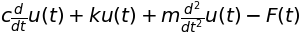

In [3]:
eq_mo = m * u(t).diff(t).diff(t) + c * u(t).diff(t) + k * u(t) - F(t)
eq_mo

## 非減衰自由振動
---

減衰0、外力0の条件下で、初速0,初期変位1の自由振動を計算する
解くべき方程式は下記の通り。

$$
\begin{align*}
m \frac{d^2u}{dt^2}  + ku & = 0 \\
\frac{du_0}{dt} &= 0 \\
u_0 &= 1
\end{align*}
$$

m=1, k=4$\pi^2$の場合のt=0～8のu(t)を各種方法でプロットする

### Sympyによる数式処理
eq_moをそのままu(t)について解くと計算負荷が大きいので、
まずは c=0, F(t)=0を代入し非減衰自由振動方程式を作成する

非減衰自由振動方程式の左辺をeq_freeとして表示する

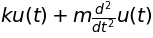

In [4]:
arg_free = {c:0, F(t):0}
eq_free = eq_mo.subs(arg_free)
eq_free

eq_freeをu(t)について解いて表示する

In [5]:
solu_free = sympy.dsolve(
        eq_free,
        u(t)
    )
solu_free

よってsolu_free（右辺）の微分よりdu/dtは

In [6]:
dsolu_freedt = sympy.diff(solu_free.rhs,t)
dsolu_freedt

t=0のとき、下記の境界条件があるので

$$
\begin{align*}
\frac{du_0}{dt} &= 0 \\
u_0 &= 1
\end{align*}
$$

連立方程式を解くとC1,C2は以下の通りである

In [7]:
dict_ci = sympy.solve(
    [solu_free.rhs.subs(t,0) - 1., 
     dsolu_freedt.subs(t,0)- 0.],
    [C1,C2])
dict_ci

上記で求めたC1,C2とm=1,k=4をsolu_freeに代入すると、

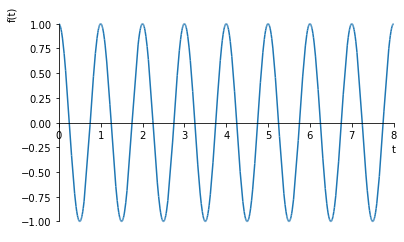

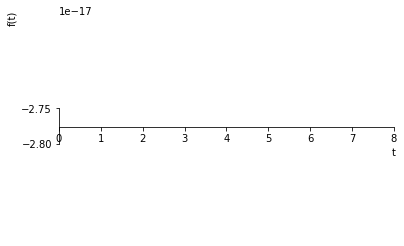

In [8]:
real_react_free, img_react_free = solu_free.subs(dict_ci).subs({m:1,k:4*np.pi**2.}).rhs.as_real_imag()

sympy.plotting.plot(real_react_free, (t,0,8))
sympy.plotting.plot(img_react_free, (t,0,8))

虚部が消えて実部だけになっていることが確認でき、解析的に階を得られた。
また下記の通り、1Hzの固有周波数で自由振動していることがわかる。

$$
\begin{align*}
f &= \frac{1}{2\pi}\sqrt\frac{k}{m} \\
f &= 1.0  \quad [Hz]
\end{align*}
$$


### Scipyによる数値計算
scipyのodeint（常微分方程式）ソルバを用いて同様の非減衰自由振動問題を計算する。

$$
\begin{align*}
m \frac{d^2}{dt^2}u  + ku & = 0 \\
\frac{du_0}{dt} &= 0 \\
u_0 &= 1
\end{align*}
$$
まずはscipyを使う準備
1. matplotlibライブラリのpyplotモジュールをpltという名称でインポート
2. scipy.integrateモジュール内のode関数をインポート

In [9]:
from matplotlib import pyplot as plt
from scipy.integrate import odeint

まずは、下記のように変数変換を考える

$$
\frac{d}{dt}u := v
$$

この関係を考慮すれば、２階の常微分方程式が１階の連立常微分方程式で表現できる

$$
\begin{align*}
\left\{
    \begin{array}{l}
        \large \frac{d}{dt} \normalsize v = - \large \frac{k}{m} \normalsize u  \\
        \large \frac{d}{dt} \normalsize u= v
     \end{array}
\right.
\end{align*}
$$

変数x(=(v,u))でまとめ、xと時間tを引数として$\large \left[ \frac{dv}{dt},\frac{du}{dt}\right]$を返す関数func_odeを定義する

In [10]:
def funcs_ode(x,t):
    dvdt = - 4. * np.pi **2 / 1. * x[1]
    dudt = x[0]
    return [dvdt, dudt]

次に、初期値x0と時間ti(0から8までを801分割したベクトル)を定義する。
(変数tはsympyにて使っているので変数名はtiとすること)

In [11]:
x0 = [0., 1.]
ti = np.linspace(0,8,801)

初期値x0でtiに示す時間ステップでxを計算し、変位uをプロットする。

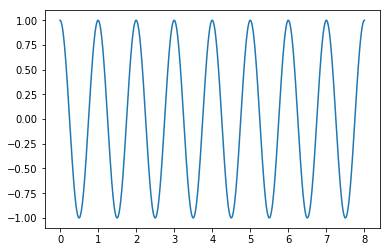

In [12]:
x = odeint(funcs_ode,x0, ti)
plt.plot(ti,x[:,1])

## 強制振動
---
m=1, k=4$\pi^2$, 減衰係数c=$0.8\pi$ (減衰比$\zeta=0.2$)、外力F(t)の条件下で
上記に示す[１質点系の強制振動](#anker1)の数値計算を行う

$$
\begin{equation*}
m \frac{d^2}{dt^2}u(t) + c \frac{d}{dt}u(t) + ku(t) = F(t)
\end{equation*}
$$

外力F(t)は下記とする。尚、sgnはシグナム関数(符号関数)である
$$
F(t) = \mbox{sgn} \hspace{1pt} sin(0.25\pi (t-1.0)) +1.0
$$

シグナム関数は正の値の場合1,負の値の場合-1を取る関数で、外力Ftは次の通りプロットできる   
時間は上で定義したtiを用いる

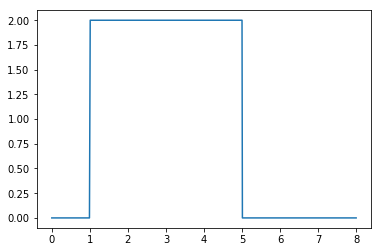

In [13]:
Ft = np.sign(np.sin(0.25*np.pi*(ti-1) )) +1
plt.plot(ti,Ft)

まずは、前項と同じように変数変換を考える

$$
\frac{d}{dt}u := v
$$

この関係を考慮すれば、前項同様に２階の常微分方程式が１階の連立常微分方程式で表現できる

$$
\begin{align*}
\left\{
    \begin{array}{l}
        \large \frac{d}{dt} \normalsize v = F(t)- \large \frac{c}{m} \normalsize v  - \large \frac{k}{m} \normalsize u  \\
        \large \frac{d}{dt} \normalsize u= v
     \end{array}
\right.
\end{align*}
$$

変数x(=(v,u))でまとめ、xと時間tを引数として$\large \left[ \frac{dv}{dt},\frac{du}{dt}\right]$を返す関数func_ode2を定義する

In [14]:
def funcs_ode2(x,t):
    dvdt = np.sign(np.sin(0.25*np.pi*(t-1.))) +1. - 0.8 * np.pi  / 1. * x[0] - 4. * np.pi **2 / 1. * x[1]
    dudt = x[0]
    return [dvdt, dudt]

今回は外力の応答を見たいので、初期値は速度、変位ともに0,0とする。  
時間は前項同様の変数ti(0から8までを801分割したベクトル)を再定義する。（前回定義しているなら不要）

In [15]:
x0 = [0., 0.]
ti = np.linspace(0,8,801)

初期値x0でtiに示す時間ステップでxを計算し、変位uをプロットする。

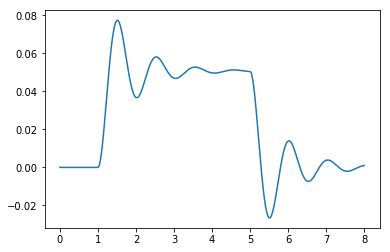

In [16]:
x = odeint(funcs_ode2,x0, ti)
plt.plot(ti,x[:,1])

時刻1[s]より応答変位が生じている。約4[s]地点で準静的な力のつり合い状態となっていることがわかる。

---
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img align="right" alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><br />
<div align="right"><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">python4engineer</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="https://github.com/TatsuyaKatayama/python4engineer" property="cc:attributionName" rel="cc:attributionURL">TatsuyaKatayama</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. </div>
